# Import libraries

In [1]:
### import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from matplotlib.dates import DateFormatter

import glob, os
from datetime import datetime as dt
from datetime import timedelta
from datetime import timezone
import pytz
from math import sin, cos, sqrt, atan2, radians
from scipy.optimize import minimize
from scipy import stats

### import Dask library (https://dask.org/)
import dask
import dask.dataframe as dd
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.distributed import Client

### import geospatial libraries
import geopandas as gpd
import contextily as ctx
import pyproj

### import data4resilience toolkit 
from d4r_toolkit import data_preprocess
from d4r_toolkit import displacement
from d4r_toolkit import mobanalytics
from d4r_toolkit import utils
from d4r_toolkit import viz

In [1]:
# client = Client(n_workers=5) ### choose number of cores to use
# client

In [2]:
### directory that contains dataset(s) you want to analyze
filepath = "D:/WB_Mexico/gpsdata_eq/testdata_all/"
toolkitpath = "C:/Users/yabec/PythonScripts/WB_Mexico/Toolkit/"
datapath = toolkitpath+"data/"
outpath  = toolkitpath+"results/"

# Import external data 
## Administrative boundary shapefiles

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


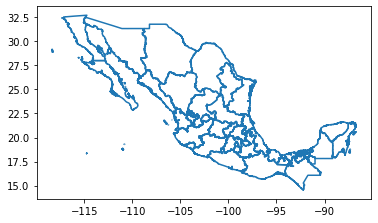

In [3]:
fig,ax = plt.subplots()
adm1_f = datapath+"spatial/boundaries_shapefiles/mex_admbnda_adm1_govmex/"
adm1_shp = gpd.read_file(adm1_f)
adm1_shp.boundary.plot(ax=ax)
# plt.savefig("C:/users/yabec/desktop/abm1.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

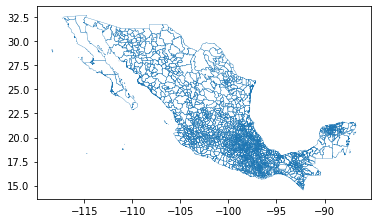

In [160]:
fig,ax = plt.subplots()
adm2_f = datapath+"spatial/boundaries_shapefiles/mex_admbnda_adm2_govmex/"
adm2_shp = gpd.read_file(adm2_f)
adm2_shp = adm2_shp[["ADM2_PCODE","ADM2_ES","geometry"]]
adm2_shp.boundary.plot(ax=ax, linewidth=.3)
# plt.savefig("C:/users/yabec/desktop/abm2.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [5]:
adm2_shp.head()

,ADM2_PCODE,ADM2_ES,geometry
0,MX01001,Aguascalientes,"POLYGON ((-102.09775 22.02325, -102.09857 22.0..."
1,MX01002,Asientos,"POLYGON ((-101.99941 22.21951, -101.99940 22.2..."
2,MX01003,Calvillo,"POLYGON ((-102.57625 21.96778, -102.57626 21.9..."
3,MX01004,Cos,"POLYGON ((-102.25320 22.37449, -102.25239 22.3..."
4,MX01005,Jes,"POLYGON ((-102.31034 22.03716, -102.30653 22.0..."


In [6]:
# adm2_shp = adm2_shp[["ADM2_PCODE","geometry"]]

In [7]:
# adm2_shp["code"] = adm2_shp["ADM2_PCODE"].apply(lambda x : x[2:4])

In [8]:
# adm2_shp = adm2_shp[adm2_shp["code"].isin(["09","17","21","29"])]
adm2_shp.head()

,ADM2_PCODE,ADM2_ES,geometry
0,MX01001,Aguascalientes,"POLYGON ((-102.09775 22.02325, -102.09857 22.0..."
1,MX01002,Asientos,"POLYGON ((-101.99941 22.21951, -101.99940 22.2..."
2,MX01003,Calvillo,"POLYGON ((-102.57625 21.96778, -102.57626 21.9..."
3,MX01004,Cos,"POLYGON ((-102.25320 22.37449, -102.25239 22.3..."
4,MX01005,Jes,"POLYGON ((-102.31034 22.03716, -102.30653 22.0..."


In [9]:
adm2_shp["centroid"] = adm2_shp.centroid

In [10]:
adm2_shp.geometry = adm2_shp.centroid
# adm2_shp = adm2_shp.to_crs(epsg=3857)

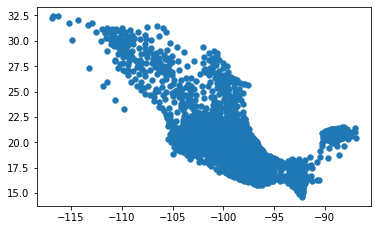

In [11]:
fig,ax = plt.subplots()
adm2_shp.plot(ax=ax, linewidth=.3)

## Seismic intensity shapefile 

In [12]:
seismic_shp_f = datapath+"spatial/seismicdata/intensity/"
seismic_shp = gpd.read_file(seismic_shp_f)[["PARAMVALUE","geometry"]]

In [13]:
seismic_shp.tail()

,PARAMVALUE,geometry
20,7.0,"MULTIPOLYGON (((-99.00292 19.21667, -99.00471 ..."
21,7.2,"MULTIPOLYGON (((-98.74806 18.85833, -98.74864 ..."
22,7.4,"MULTIPOLYGON (((-98.67707 18.80000, -98.67940 ..."
23,7.6,"MULTIPOLYGON (((-98.44767 18.70000, -98.44861 ..."
24,7.8,"MULTIPOLYGON (((-98.48333 18.39997, -98.48336 ..."


In [14]:
seismic_shp_hm = seismic_shp.to_crs(epsg=3857)

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


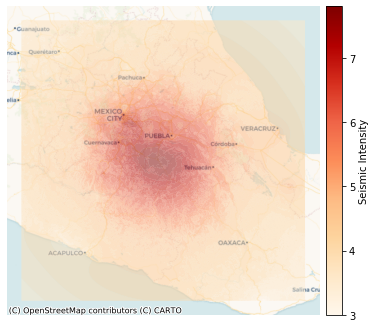

In [15]:
fig,ax = plt.subplots(1,1,figsize=(6,6)) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

seismic_shp_hm.plot(ax=ax, column='PARAMVALUE', legend=True, cmap='OrRd', 
                 cax=cax, legend_kwds={'label': "Seismic Intensity"}, 
                 zorder=2.5, alpha=0.5)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
ax.set_axis_off()

# plt.savefig("C:/users/yabec/desktop/seismic.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [16]:
adm2_SI = gpd.sjoin(adm2_shp, seismic_shp, how="left", \
                    op='intersects')[["ADM2_PCODE","PARAMVALUE"]]

In [17]:
adm2_SI[adm2_SI["ADM2_PCODE"]=="MX09002"]

,ADM2_PCODE,PARAMVALUE
265,MX09002,6.0


## Population data

In [18]:
poppath = datapath+"sociodemographic/populationdata/"
df_pop = pd.DataFrame()
for es in ["09","17","21","29"]:
    pop = poppath+"resultados_ageb_urbana_"+es+"_cpv2010.csv"
    df_pop1 = pd.read_csv(pop)[["entidad","mun","loc","ageb","mza","pobtot"]]
    df_pop = df_pop.append(df_pop1, ignore_index=True)

In [19]:
df_pop = df_pop[(df_pop["mun"]!=0) & (df_pop["loc"]==0)][["entidad","mun","pobtot"]]

In [20]:
df_pop["PCODE"] = df_pop.apply(lambda row : "MX"+str(row["entidad"]).zfill(2)+str(row["mun"]).zfill(3), axis=1)

In [21]:
df_pop.head()

,entidad,mun,pobtot,PCODE
1,9,2,414711,MX09002
3097,9,3,620416,MX09003
7970,9,4,186391,MX09004
9010,9,5,1185772,MX09005
17648,9,6,384326,MX09006


In [22]:
adm2_SI_pop = adm2_SI.merge(df_pop, left_on="ADM2_PCODE", right_on="PCODE")[["PCODE","PARAMVALUE","pobtot"]]

In [23]:
adm2_SI_pop.head()

,PCODE,PARAMVALUE,pobtot
0,MX09002,6.0,414711
1,MX09003,6.8,620416
2,MX09004,6.2,186391
3,MX09005,5.4,1185772
4,MX09006,6.6,384326


## Wealth index data 

In [24]:
wealthidx_f = datapath+"sociodemographic/wealthindex/pca_index_AGEBS_localidades.csv"
wealthidx = pd.read_csv(wealthidx_f, header=0, 
                        names = ["index","code","pca","index_pca"])
wealthidx.head()

C:\Users\yabec\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,index,code,pca,index_pca
0,0,0100100010229,-2.680167,0.147990
1,1,0100100010233,-2.701735,0.146480
2,2,0100100010286,-3.474532,0.092363
3,3,0100100010290,-3.404371,0.097277
4,4,0100100010303,-3.099987,0.118592


In [25]:
wealthidx["PCODE"] = wealthidx["code"].apply(lambda x : "MX"+str(x)[:5])

In [26]:
wealthidx_avg = wealthidx.groupby("PCODE")["index_pca"].mean().reset_index()

In [27]:
wealthidx_avg.head()

,PCODE,index_pca
0,MX01001,0.206558
1,MX01002,0.232278
2,MX01003,0.233212
3,MX01004,0.216361
4,MX01005,0.216503


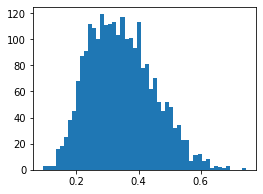

In [28]:
plt.figure(figsize=(4,3))
plt.hist(wealthidx_avg["index_pca"].values, bins=50)
plt.show()

In [29]:
adm2_SI_pop_WI = adm2_SI_pop.merge(wealthidx_avg, on="PCODE")

In [30]:
adm2_SI_pop_WI.head(10)

,PCODE,PARAMVALUE,pobtot,index_pca
0,MX09002,6.0,414711,0.124537
1,MX09003,6.8,620416,0.106024
2,MX09004,6.2,186391,0.182998
3,MX09005,5.4,1185772,0.140297
4,MX09006,6.6,384326,0.134230
5,MX09007,7.0,1815786,0.157710
6,MX09008,6.0,239086,0.181795
7,MX09009,7.0,130582,0.285495
8,MX09010,6.8,727034,0.135709
9,MX09011,7.4,360265,0.199308


# Compute displacement rate 
## get target ID list

In [2]:
idhome = "D:/WB_Mexico/results_eq/selectedids_homeloc.csv"
df_idhome = pd.read_csv(idhome,header=None, names=["id", "homelon","homelat"])
allids = set(df_idhome["id"].values)

In [67]:
len(allids)

195666

## extract data of above IDs

In [ ]:
alldataf = "D:/WB_Mexico/results_eq/selectedids_all_data.csv"

In [ ]:
displacement.getdataforIDs(alldataf, gpsroot, allids)

## get daily displacement distance

In [71]:
chunk = 10000

In [ ]:
metricsf = "D:/WB_Mexico/results_eq/id_date_metrics.csv"

In [ ]:
displacement.getdisplacementdata(metricsf, alldataf, chunk)

# Analyze displacement rates 
## id home locations 

In [31]:
idhome_gdf = gpd.GeoDataFrame(df_idhome, geometry=gpd.points_from_xy(df_idhome.homelon, df_idhome.homelat))

In [ ]:
idhome_gdf.head()

In [33]:
adm2_f = datapath+"spatial/boundaries_shapefiles/mex_admbnda_adm2_govmex/"
adm2_shp = gpd.read_file(adm2_f)
adm2_shp = adm2_shp[["ADM2_PCODE","geometry"]]

In [102]:
id_homecode = gpd.sjoin(idhome_gdf,adm2_shp)
id_homecode = id_homecode[["id","homelon","homelat","ADM2_PCODE"]].rename(columns={"ADM2_PCODE":"PCODE"}) 

C:\Users\yabec\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [ ]:
id_homecode.head()

In [ ]:
id_home_feat = id_homecode.merge(adm2_SI_pop_WI, on="PCODE")
id_home_feat.head()

In [36]:
muncode_count = id_homecode.groupby("PCODE").count().reset_index()

In [37]:
muncode_count.head()

,PCODE,id
0,MX04002,19
1,MX04003,56
2,MX04004,3
3,MX04008,1
4,MX04009,3


In [38]:
muncode_rate = muncode_count.merge(adm2_SI_pop_WI, on ="PCODE")
muncode_rate["rate"] = muncode_rate["id"]/muncode_rate["pobtot"]
muncode_rate.head()

,PCODE,id,PARAMVALUE,pobtot,index_pca,rate
0,MX09002,2921,6.0,414711,0.124537,0.007043
1,MX09003,4599,6.8,620416,0.106024,0.007413
2,MX09004,1726,6.2,186391,0.182998,0.009260
3,MX09005,6354,5.4,1185772,0.140297,0.005359
4,MX09006,2509,6.6,384326,0.134230,0.006528


## Macroscopic analysis

In [39]:
df_disp = pd.read_csv(metricsf,header=None,
                      names=["id", "date", "homelat","homelon",
                             "mindist","avgdist","lat","lon"])

In [ ]:
df_disp.head()

In [41]:
df_disp2 = df_disp.merge(id_homecode, on="id", how="left")

In [ ]:
df_disp2.head()

In [43]:
df_disp3 = df_disp2.merge(adm2_SI_pop_WI, on="PCODE", how="left")

In [ ]:
df_disp3.head()

In [45]:
def categorizeSI(si):
    if si>=7:
        r = 7
    elif si>=6.5:
        r = 6.5
    elif si>=6:
        r = 6
    elif si >=5:
        r = 5
    elif si >=4:
        r = 4
    else:
        r = 0
    return r

In [46]:
df_disp3["SI_cat"] = df_disp3["PARAMVALUE"].apply(lambda x : categorizeSI(x))

In [ ]:
df_disp3.head()

## displacement rates

In [ ]:
df_disp4 = df_disp3[df_disp3["lon"]!=0] 
df_disp4.head()

In [50]:
dist = "mindist"
df_disp4["500m"] = df_disp4[dist].apply(lambda x : 1 if x>0.5 else 0)
df_disp4["1km"] = df_disp4[dist].apply(lambda x : 1 if x>1 else 0)
df_disp4["3km"] = df_disp4[dist].apply(lambda x : 1 if x>3 else 0)
df_disp4["5km"] = df_disp4[dist].apply(lambda x : 1 if x>5 else 0)
df_disp4["10km"] = df_disp4[dist].apply(lambda x : 1 if x>10 else 0)

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
df_disp4.head()

In [ ]:
si_count = df_disp4[df_disp4["date"]==20170910].groupby('SI_cat').count().reset_index()
si_count

## displacement time series plot by SI

In [475]:
# df_idinfo = df_disp_se[["id","pcode","epi_dist","si_round","wi_round"]]

In [53]:
sis = sorted(set(df_disp4["SI_cat"]))
sis = [5.0, 6.0, 6.5, 7.0]

In [54]:
cms = plt.get_cmap("jet",len(sis))

In [57]:
scale = "500m"

In [3]:
df_this = df_disp4[df_disp4["SI_cat"]==0]
date_disp = df_this.groupby('date').mean().reset_index()
date_disp["date_dt"] = date_disp["date"].apply(lambda x : dt.strptime(str(x), '%Y%m%d'))
baseline = date_disp["500m"].values

In [165]:
def plotforSI(df_disp_se,si,ax,color, category, label, ylab, colname, baseline):
    df_this = df_disp_se[df_disp_se[category]==si]
    date_count = df_this.groupby('date').count().reset_index()[["date","id"]]
    date_std = df_this.groupby('date').std().reset_index()[["date",colname]]
    date_std = date_std.rename(columns= {colname:"std"})
    date_disp = df_this.groupby('date').mean().reset_index()
    date_disp["date_dt"] = date_disp["date"].apply(lambda x : dt.strptime(str(x), '%Y%m%d'))
    date_disp["youbi"] = date_disp["date_dt"].apply(lambda x : x.weekday())
    date_disp = date_disp.merge(date_count, on="date")
    date_disp = date_disp.merge(date_std, on="date")

    data = date_disp[colname].values
    a = fit_baseline(data, baseline)
    res = (a*data-baseline)*100
    ax.plot(date_disp["date_dt"],res, color=color, label="Estimated")
    date_disp["error"] = date_disp.apply(lambda x : 196*np.sqrt((x[colname]*(1-x[colname]))/x["id"]), \
                                             axis=1)
    
    ax.fill_between(date_disp["date_dt"],res-date_disp["error"].values, \
                    res+date_disp["error"].values, 
                    color=color, alpha=0.3, label="95% CI")
    ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
    ax.axhline(0, color="gray")
    ax.set_xticks(["20170905","20170915","20170925","20171005"])
    ax.set_ylim(-2.5,6)
    ax.set_ylabel(ylab[0], fontsize=12)
    ax.axvline("20170919", color="red")
    ax.legend(fontsize=12, ncol=5, loc="upper left")
    ax.set_title(label, fontsize=14)

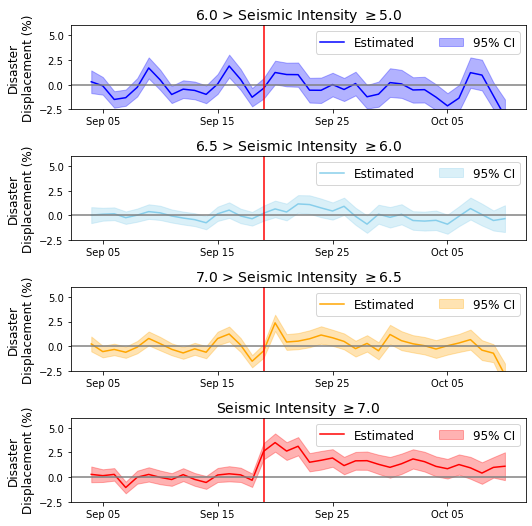

In [137]:
fig=plt.figure(figsize=(7.5,9))
gs=GridSpec(5,1)

res_si = {}

category = "SI_cat"
ylabs = ["Disaster\nDisplacement (%)", "$\Delta D$"]
colors = ["blue", "skyblue", "orange", "red"]
titles = ["6.0 > Seismic Intensity "+r"$\geq$"+"5.0", 
          "6.5 > Seismic Intensity "+r"$\geq$"+"6.0", 
          "7.0 > Seismic Intensity "+r"$\geq$"+"6.5",
          "Seismic Intensity "+r"$\geq$"+"7.0"]
for si,i in zip(sis,np.arange(len(sis))):
    ax = fig.add_subplot(gs[i,0]) 
    plotforSI(df_disp4, si, ax, colors[i], category, titles[i], ylabs, scale, baseline)        

plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/displacement_si.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

## displacement rate by wealth index

In [141]:
df_disp_se_5 = df_disp4[df_disp4["SI_cat"]>=6.5]

In [142]:
aaa = df_disp_se_5[df_disp_se_5["date"]==20170917].groupby("index_pca")["500m"].mean().reset_index()
bbb = df_disp_se_5[df_disp_se_5["date"]==20170917].groupby("index_pca")["500m"].count().reset_index()

In [147]:
x = aaa["index_pca"].values
y = aaa["500m"].values
z = bbb["500m"].values
newz = []
xx = []
yy = []
for k,j,i in zip(x,y,z):
    if i > 20:
        xx.append(k)
        yy.append(j*100-baseline[15]*100)
        newz.append(np.sqrt(i)*5)

-20.287633271139935 4.177238284485643 -0.3296320357111983 0.03532417889280895 9.304478374530346


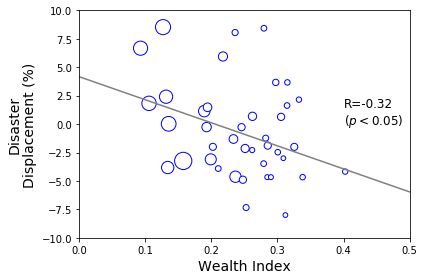

In [153]:
plt.scatter(xx, yy, s=newz, edgecolor="b", facecolor="white")
c1, i1, s1, p_value, std_err = stats.linregress(xx,yy)
print(c1, i1, s1, p_value, std_err)
plt.plot([0,1],[i1,i1+c1], linestyle="-", color="gray") 
plt.annotate("R="+str(s1)[:5]+"\n($p<0.05$)", xy=(0.4,0), fontsize=12)
plt.ylim(-10,10)
plt.xlim(0,0.5)
plt.xlabel("Wealth Index", fontsize=14)
plt.ylabel("Disaster\nDisplacement (%)", fontsize=14)

plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/wealth_disp.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

## look at high damage + sample rate areas in detail

In [154]:
### merge with disaster damage data (below)
muncode_rate.head()

,PCODE,id,PARAMVALUE,pobtot,index_pca,rate
0,MX09002,2921,6.0,414711,0.124537,0.007043
1,MX09003,4599,6.8,620416,0.106024,0.007413
2,MX09004,1726,6.2,186391,0.182998,0.009260
3,MX09005,6354,5.4,1185772,0.140297,0.005359
4,MX09006,2509,6.6,384326,0.134230,0.006528


In [155]:
muncode_rate["idlog"] = muncode_rate["id"].apply(lambda x : np.log10(x))

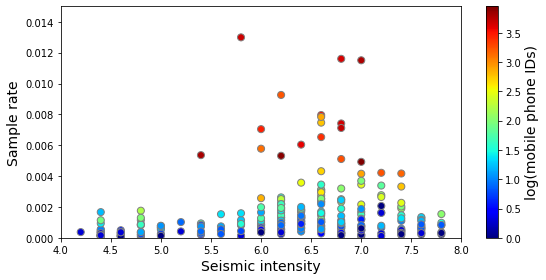

In [156]:
fig=plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)
muncode_rate.plot.scatter("PARAMVALUE","rate",c='idlog', 
                               colormap='jet', edgecolor="gray", s=50,ax=ax)
ax.set_xlim(4,8)
ax.set_ylim(0,0.015)
# ax.set_xticklabels([4,5,6,7,8])
ax.set_xlabel("Seismic intensity", fontsize=14)
ax.set_ylabel("Sample rate", fontsize=14)

f = plt.gcf()
cax = f.get_axes()[1]
cax.set_ylabel('log(mobile phone IDs)', fontsize=14)

plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/samplerate_si.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [157]:
target = muncode_rate[(muncode_rate["PARAMVALUE"]>=6.5) & (muncode_rate["id"]>=3000)]
target

,PCODE,id,PARAMVALUE,pobtot,index_pca,rate,idlog
1,MX09003,4599,6.8,620416,0.106024,0.007413,3.662663
5,MX09007,8940,7.0,1815786,0.157710,0.004923,3.951338
8,MX09010,5176,6.8,727034,0.135709,0.007119,3.713994
12,MX09014,4472,6.8,385439,0.093186,0.011602,3.650502
13,MX09015,6120,7.0,531831,0.127169,0.011507,3.786751
15,MX09017,3429,6.6,430978,0.131777,0.007956,3.535167


In [158]:
targetcodes = target["PCODE"].values
targetcodes = ['MX09015', 'MX09003', 'MX09010', 'MX09007', 'MX09014', 'MX09017']

In [161]:
names = []
for t in targetcodes:
    name = adm2_shp[adm2_shp["ADM2_PCODE"]==t]["ADM2_ES"].values[0]
    SI = target[target["PCODE"]==t]["PARAMVALUE"].values[0]
    ids = target[target["PCODE"]==t]["id"].values[0]
    if "Cua" in name:
        name = "Cuauhtemoc"
    elif "lvaro" in name:
        name = "Olvaro Obregzn"
    names.append(name+" (code: "+t+", SI="+str(SI)+", Users="+str(ids)+")")
    
names

['Cuauhtemoc (code: MX09015, SI=7.0, Users=6120)',
 'Coyoacln (code: MX09003, SI=6.8, Users=4599)',
 'Olvaro Obregzn (code: MX09010, SI=6.8, Users=5176)',
 'Iztapalapa (code: MX09007, SI=7.0, Users=8940)',
 'Benito Julrez (code: MX09014, SI=6.8, Users=4472)',
 'Venustiano Carranza (code: MX09017, SI=6.6, Users=3429)']

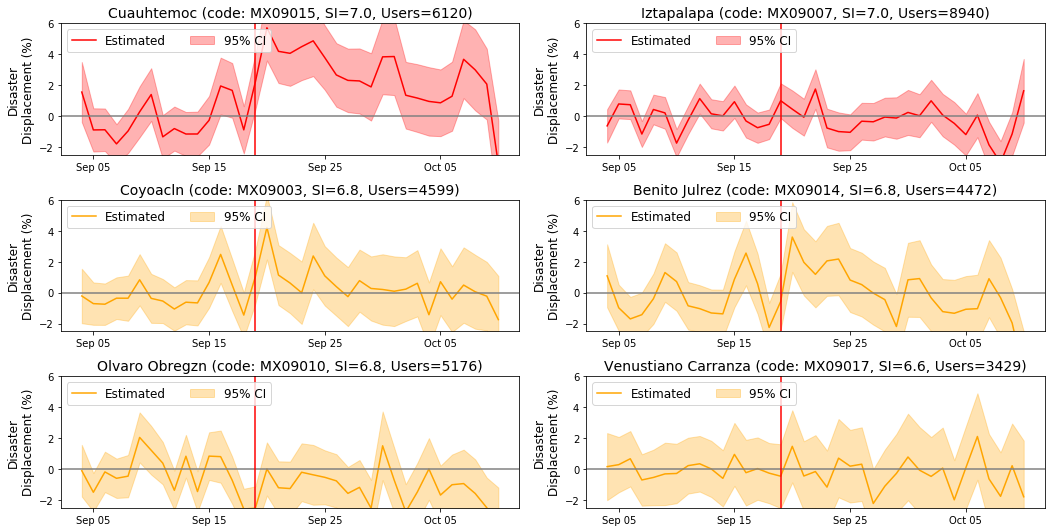

In [166]:
fig=plt.figure(figsize=(15,2.5*3))
gs=GridSpec(3,2)

res_si = {}

category = "PCODE"
ylabs = ["Disaster\nDisplacement (%)", "$\Delta D$"]
colors = ["red", "orange", "orange", "red", "orange", "orange", "orange"]
titles = names

for i,pcode in enumerate(targetcodes):
    x,y = i, 0
    if i>2:
        y = 1
        x = i - 3
#     print(x,y)
    ax = fig.add_subplot(gs[x,y]) 
    plotforSI(df_disp4, pcode, ax, colors[i], category, titles[i], ylabs, scale, baseline)        

plt.tight_layout()
# plt.savefig("C:/users/yabec/desktop/displacement_places.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

## Cuahtlemoc

In [687]:
date = 20170920
df_disp4_cua = df_disp4[(df_disp4["PCODE"]=="MX09015") & (df_disp4["date"]==date)]
df_disp4_cua["distance"] = df_disp4_cua.apply(lambda row: np.log10(distance(row["homelat"],row["homelon"],row["lat"],row["lon"])),axis=1)

# df_disp4_cua = df_disp4_cua[(df_disp4_cua["distance"]>2)]

df_disp4_cua = df_disp4_cua[((df_disp4_cua["distance"]>0.5) & (df_disp4_cua["distance"]<1.5))]

# df_disp4_cua = df_disp4_cua[((df_disp4_cua["distance"]>0.5) & (df_disp4_cua["distance"]<1.5)) | (df_disp4_cua["distance"]<-1)]

df_disp4_cua_gdf = gpd.GeoDataFrame(df_disp4_cua, geometry=gpd.points_from_xy(df_disp4_cua.lon, df_disp4_cua.lat))
df_disp4_cua_gdf = df_disp4_cua_gdf[["id","geometry"]]

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [688]:
df_disp4_cua_gdf.columns

Index(['id', 'geometry'], dtype='object')

In [689]:
df_disp4_cua_to = gpd.sjoin(df_disp4_cua_gdf,adm2_shp)

C:\Users\yabec\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [690]:
targetcode_count = df_disp4_cua_to.groupby("ADM2_PCODE")["id"].count().reset_index()
targetcode_count["idlog"] = targetcode_count["id"].apply(lambda x : np.log10(x))
targetcode_count.head(5)

,ADM2_PCODE,id,idlog
0,MX09002,10,1.000000
1,MX09003,20,1.301030
2,MX09004,6,0.778151
3,MX09005,22,1.342423
4,MX09006,7,0.845098


In [691]:
mun_ids_pop_shp = adm2_shp.merge(targetcode_count, on="ADM2_PCODE", how="right")
mun_ids_pop_shp = mun_ids_pop_shp.to_crs(epsg=3857)

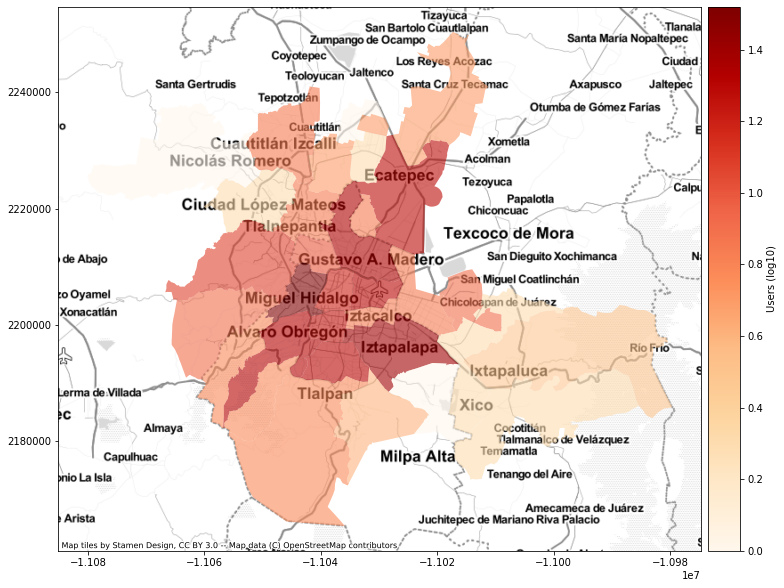

In [692]:
fig,ax = plt.subplots(figsize=(20,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
mun_ids_pop_shp.plot(ax=ax, column='idlog', cmap='OrRd', legend=True, 
                    cax=cax, legend_kwds={'label': "Users (log10)"}, alpha=.6)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
# plt.savefig("C:/users/yabec/desktop/displacement_10km.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()

In [640]:
df_disp4_cua["distance"] = df_disp4_cua.apply(lambda row: np.log10(utils.distance(row["homelat"],row["homelon"],row["lat"],row["lon"])),axis=1)

C:\Users\yabec\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


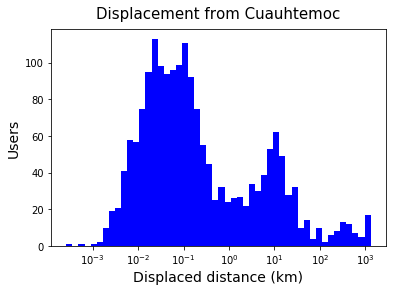

In [655]:
fig,ax = plt.subplots(figsize=(6,4))

ax.hist(df_disp4_cua["distance"].values, bins=50, color="b")
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(["$10^{-3}$","$10^{-2}$","$10^{-1}$","$10^{0}$",
                    "$10^{1}$","$10^{2}$","$10^{3}$"])
ax.set_xlabel("Displaced distance (km)", fontsize=14)
ax.set_ylabel("Users", fontsize=14)
ax.set_title("Displacement from Cuauhtemoc", fontsize=15, pad=10)

# plt.savefig("C:/users/yabec/desktop/displacement_distance.png",
#             dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()